# Preprocessing

In [145]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

def load_ipeds_unis(fname='../data/IPEDS/hd2020.csv', encoding='cp1252'):
    return pd.read_csv(fname, encoding=encoding)

def filter_only_rs_and_las(unis):
    unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
    unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')
    return unis

def preprocess_names(unis):
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS'] =='Virginia Tech', 'INSTNM']                                            = 'Virginia Tech'
    unis.loc[unis['INSTNM'] =='University of Illinois Urbana-Champaign', 'INSTNM']                  = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM']             = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM']             = "St. John's College - NM"
    unis.loc[unis['INSTNM'] =="William & Mary", 'INSTNM']                                           = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM']      = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
    return unis

def fetch_rankings(fname='../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5,\
                   usecols=['Institution Name', 'Full Time Enrollment', 'Ranking List', 'Rank'], top=-1):
    
    rankings = pd.read_excel(fname,skiprows=skiprows, usecols=usecols)
    
    if top > -1:
        rankings = rankings[rankings['Rank']<=top]
        
    return rankings

unis     = load_ipeds_unis()
unis     = filter_only_rs_and_las(unis)
unis     = preprocess_names(unis)

rankings = fetch_rankings(top=100)

merged   = pd.merge(unis, rankings, left_on='INSTNM', right_on='Institution Name')

print("Missing unis: %s " % set(rankings['Institution Name']).difference(merged['INSTNM']))

Missing unis: set() 


# CS vs. other majors

In [334]:

fnames         = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
# dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])


var, var_alt   = 'CTOTALW', 'CRACE16' 
women_abs      = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
women_abs      = pd.concat(women_abs, axis=1).transpose()

var, var_alt   = 'CBKAAT', 'CRACE18' 
black_abs      = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
black_abs      = pd.concat(black_abs, axis=1).transpose()

var, var_alt   = 'CHISPT', 'CRACE21'
hispanic_abs   = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
hispanic_abs   = pd.concat(hispanic_abs, axis=1).transpose()

var, var_alt   = 'CAIANT', 'CRACE19'
natives_abs    = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
natives_abs    = pd.concat(natives_abs, axis=1).transpose()

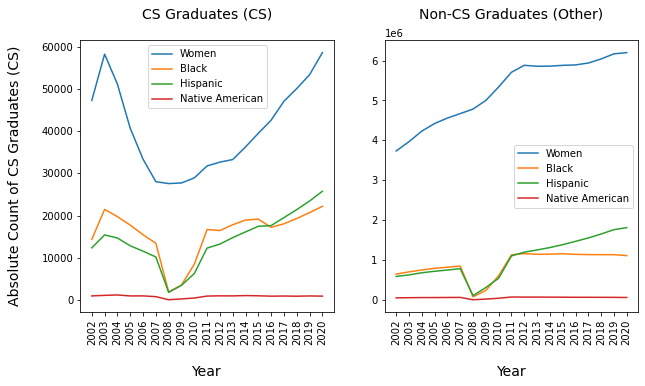

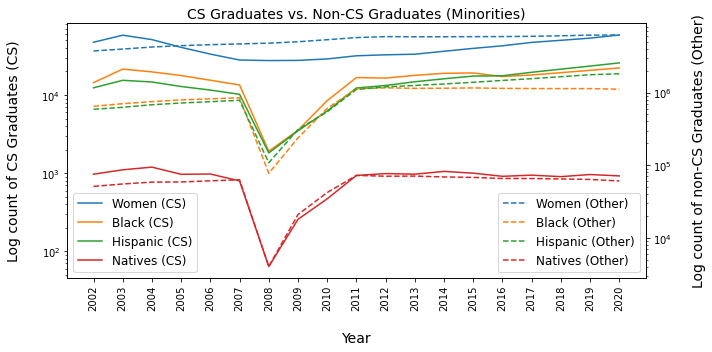

In [335]:
fig, axs       = plt.subplots(1, 2, figsize=(10,5))

_ = [axs[0].plot(df) for df in [women_abs[True], black_abs[True], hispanic_abs[True], natives_abs[True]]]
axs[0].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[0].set_title('CS Graduates (CS)\n', color='black', fontsize=14);
axs[0].legend(['Women', 'Black', 'Hispanic', 'Native American']);

_ = [axs[1].plot(df) for df in [women_abs[False], black_abs[False], hispanic_abs[False], natives_abs[False]]]
axs[1].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[1].set_title('Non-CS Graduates (Other)\n', color='black', fontsize=14);
axs[1].legend(['Women', 'Black', 'Hispanic', 'Native American']);

axs[0].set_ylabel('Absolute Count of CS Graduates (CS)\n', color='black', fontsize=14);
axs[0].set_xlabel('\nYear', color='black', fontsize=14);
axs[1].set_xlabel('\nYear', color='black', fontsize=14);

fig, ax1 = plt.subplots(figsize=(10,5))
ax2      = ax1.twinx()

_ = [ax1.plot(df, label=label) for df, label in [(women_abs[True],   'Women (CS)'),    (black_abs[True],   'Black (CS)'),\
                                                 (hispanic_abs[True],'Hispanic (CS)'), (natives_abs[True], 'Natives (CS)')]]

_ = [ax2.plot(df, label=label, linestyle='--') for df, label in [(women_abs[False], 'Women (Other)'),       (black_abs[False], 'Black (Other)'),\
                                                                 (hispanic_abs[False], 'Hispanic (Other)'), (natives_abs[False], 'Natives (Other)')]]

ax1.set_xticks(range(len(years)), sorted(years), rotation=90);
ax2.set_xticks(range(len(years)), sorted(years), rotation=90);

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

ax1.set_yscale('log');
ax2.set_yscale('log');
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='lower right', fontsize=12)

ax1.set_ylabel('Log count of CS Graduates (CS)\n', color='black', fontsize=14)
ax2.set_ylabel('\nLog count of non-CS Graduates (Other)', color='black', fontsize=14)

ax1.set_xlabel('\nYear', fontsize=14);
ax2.set_xlabel('Year', fontsize=14);

plt.title('CS Graduates vs. Non-CS Graduates (Minorities)', fontsize=14);
plt.tight_layout();

# Percentages: 

In [297]:
fnames         = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
# dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])

In [320]:

var, var_alt   = 'CTOTALW', 'CRACE16' 
women_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())      if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()   if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]


var, var_alt   = 'CBKAAT', 'CRACE18' 
black_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]


var, var_alt   = 'CHISPT', 'CRACE21'
hispanic_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]


var, var_alt   = 'CAIANT', 'CRACE19'
natives_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]

women_pct      = pd.concat(women_pct, axis=1).transpose()
black_pct      = pd.concat(black_pct, axis=1).transpose()
hispanic_pct   = pd.concat(hispanic_pct, axis=1).transpose()
natives_pct    = pd.concat(natives_pct, axis=1).transpose()

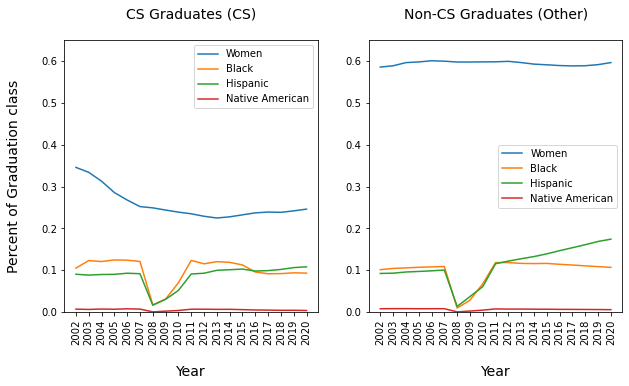

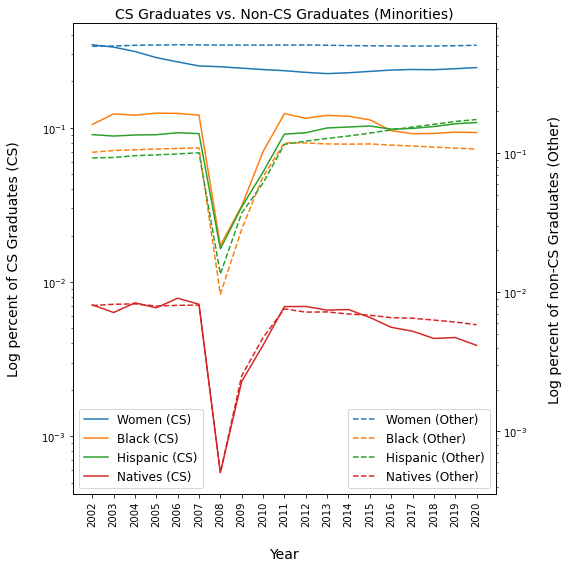

In [330]:
fig, axs       = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(women_pct[True])
axs[0].plot(black_pct[True])
axs[0].plot(hispanic_pct[True])
axs[0].plot(natives_pct[True])
axs[0].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[0].set_title('CS Graduates (CS)\n', color='black', fontsize=14);
axs[0].legend(['Women', 'Black', 'Hispanic', 'Native American']);

axs[1].plot(women_pct[False])
axs[1].plot(black_pct[False])
axs[1].plot(hispanic_pct[False])
axs[1].plot(natives_pct[False])
axs[1].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[1].set_title('Non-CS Graduates (Other)\n', color='black', fontsize=14);
axs[1].legend(['Women', 'Black', 'Hispanic', 'Native American']);

axs[0].set_ylabel('Percent of Graduation class\n', color='black', fontsize=14);
axs[0].set_xlabel('\nYear', color='black', fontsize=14);
axs[1].set_xlabel('\nYear', color='black', fontsize=14);

axs[0].set_ylim(0, 0.65);
axs[1].set_ylim(0, 0.65);

fig, ax1 = plt.subplots(figsize=(8,8))
ax2      = ax1.twinx()

ax1.plot(women_pct[True],     label='Women (CS)')
ax1.plot(black_pct[True],     label='Black (CS)')
ax1.plot(hispanic_pct[True],  label='Hispanic (CS)')
ax1.plot(natives_pct[True],   label='Natives (CS)')

ax2.plot(women_pct[False],    label='Women (Other)',    linestyle='--')
ax2.plot(black_pct[False],    label='Black (Other)',    linestyle='--')
ax2.plot(hispanic_pct[False], label='Hispanic (Other)', linestyle='--')
ax2.plot(natives_pct[False],  label='Natives (Other)',  linestyle='--')

ax1.set_xticks(range(len(years)), sorted(years), rotation=90);
ax2.set_xticks(range(len(years)), sorted(years), rotation=90);

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

ax1.set_yscale('log');
ax2.set_yscale('log');
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='lower right', fontsize=12)

ax1.set_ylabel('Log percent of CS Graduates (CS)\n', color='black', fontsize=14)
ax2.set_ylabel('\nLog percent of non-CS Graduates (Other)', color='black', fontsize=14)

ax1.set_xlabel('\nYear', fontsize=14);
ax2.set_xlabel('Year', fontsize=14);

plt.title('CS Graduates vs. Non-CS Graduates (Minorities)', fontsize=14);
plt.tight_layout();

In [193]:
years = list(cs_results.keys())
commonids = set(cs_results[years[0]].index)
for year in years[1:]:
    commonids = commonids.intersection(set(cs_results[year].index))
    
all_years_cs = pd.concat([cs_results[year].loc[commonids] for year in years], axis=1)
merged_cs = pd.merge(unis2, all_years_cs, left_on='UNITID', right_index=True)

In [194]:
years = list(non_cs_results.keys())
commonids = set(non_cs_results[years[0]].index)
for year in years[1:]:
    commonids = commonids.intersection(set(non_cs_results[year].index))
    
all_years_noncs = pd.concat([non_cs_results[year].loc[commonids] for year in years], axis=1)
merged_noncs = pd.merge(unis2, all_years_noncs, left_on='UNITID', right_index=True)

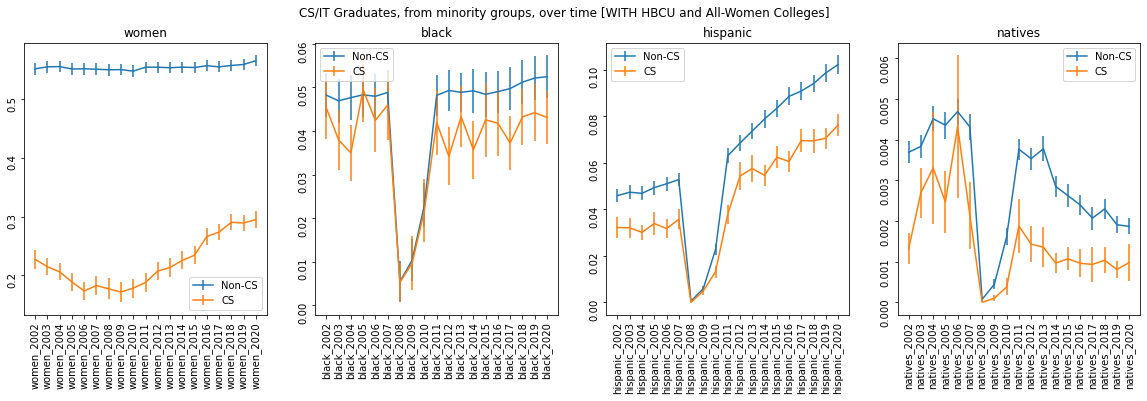

In [196]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# axs = [x for ax in axs for x in ax]

for i, (label, var, var_alt) in enumerate([women, black, hispanic, natives]):
    
    years_sorted = sorted([col for col in merged_cs.columns if label in col])
    
    '''Filter for non-HBCUs and mixed gender schools'''
    
    noncs_means = merged_noncs.mean()[years_sorted]
    noncs_sems  = merged_noncs.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=noncs_means, yerr=noncs_sems)

    cs_means = merged_cs.mean()[years_sorted]
    cs_sems  = merged_cs.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=cs_means, yerr=cs_sems)

    # axs[i].set_xticks(axs[i].xticks(), [x.split('_')[1] for x in years_sorted])    
    axs[i].tick_params(labelrotation=90)
    axs[i].set_title(label)

    axs[i].legend(['Non-CS', 'CS'])

fig.suptitle('CS/IT Graduates, from minority groups, over time [WITH HBCU and All-Women Colleges]');

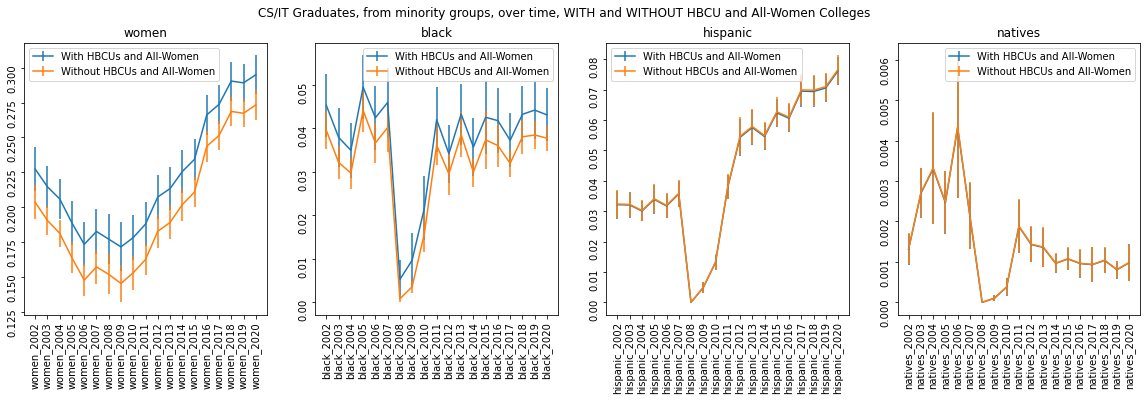

In [177]:


fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# axs = [x for ax in axs for x in ax]

for i, (label, var, var_alt) in enumerate([women, black, hispanic, natives]):
    
    years_sorted = sorted([col for col in merged_cs.columns if label in col])
    
    '''Filter for non-HBCUs and mixed gender schools'''
    
    cs_means = merged.mean()[years_sorted]
    cs_sems  = merged.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=cs_means, yerr=cs_sems)

    filtered = merged[merged['HBCU']==2]
    filtered = filtered[filtered.apply(lambda x: np.all(x[years_sorted]==1)==False, axis=1)]
    # filtered = merged

    cs_means = filtered.mean()[years_sorted]
    cs_sems  = filtered.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=cs_means, yerr=cs_sems)

    # axs[i].set_xticks(axs[i].xticks(), [x.split('_')[1] for x in years_sorted])    
    axs[i].tick_params(labelrotation=90)
    axs[i].set_title(label)

    axs[i].legend(['With HBCUs and All-Women', 'Without HBCUs and All-Women'])

fig.suptitle('CS/IT Graduates, from minority groups, over time, WITH and WITHOUT HBCU and All-Women Colleges');

# Regional Patterns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


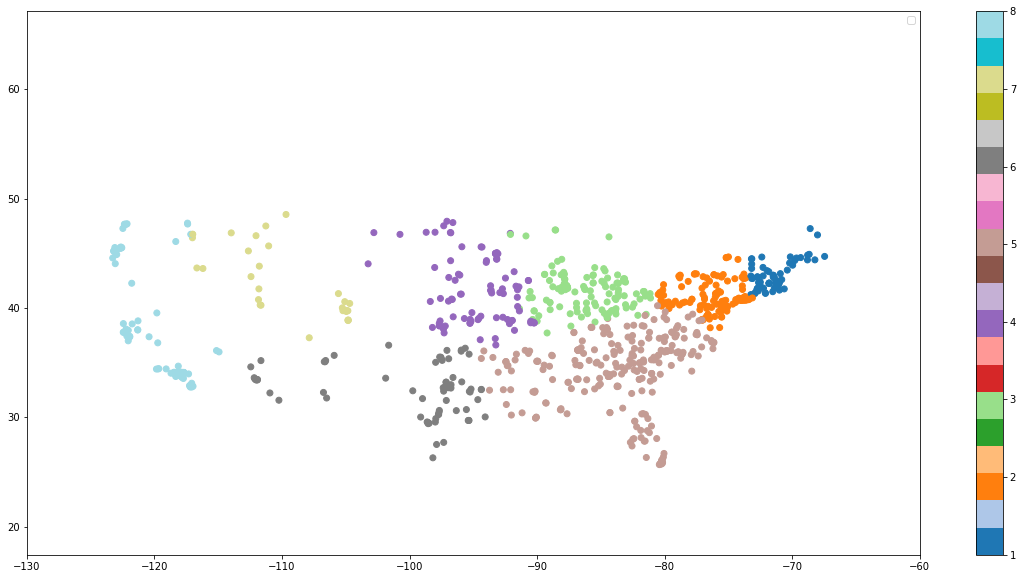

In [438]:
plt.figure(figsize=(20, 10))
filtered = unis[unis['OBEREG'].apply(lambda x: x in range(1, 9))]
plt.scatter(filtered['LONGITUD'], filtered['LATITUDE'], c=filtered['OBEREG'], cmap='tab20')
plt.colorbar()
plt.xlim((-130, -60))


plt.legend()

In [ ]:

fnames         = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
# dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])

cs_and_noncs   = [(year, df.rename(columns={col: col.upper().strip() for col in df.columns})) for year, df in cs_and_noncs]
cs_and_noncs   = [(year, pd.merge(unis[['UNITID', 'OBEREG']], df, on='UNITID')) for year, df in cs_and_noncs]

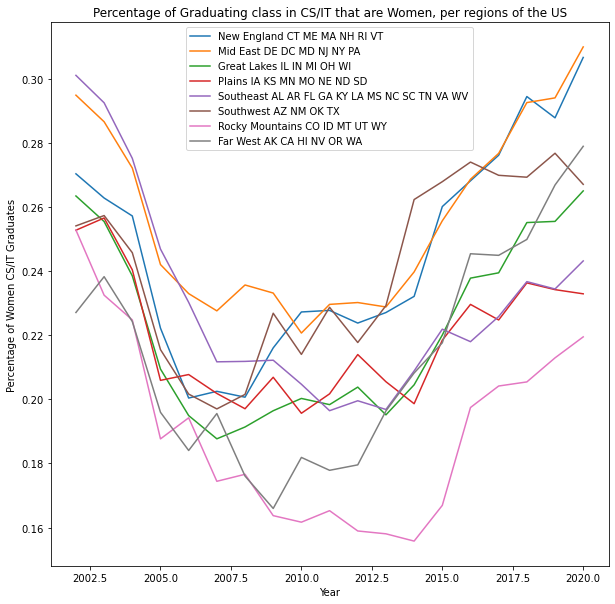

In [437]:
var, var_alt   = 'CTOTALW', 'CRACE16' 
women_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())      if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()   if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(women_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]

cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]

plt.figure(figsize=(10, 10))
cs.apply(lambda x: plt.plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA'])

plt.xlabel('Year');
plt.ylabel('Percentage of Women CS/IT Graduates');
plt.title('Percentage of Graduating class in CS/IT that are Women, per regions of the US');

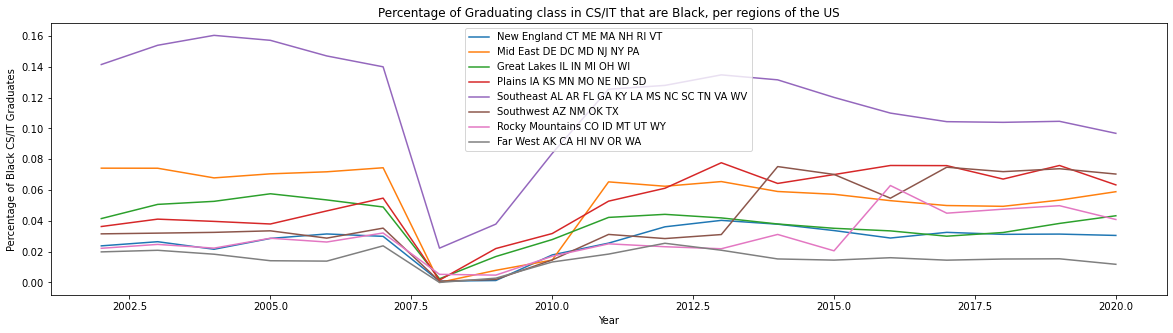

In [439]:
var, var_alt   = 'CBKAAT', 'CRACE18' 
black_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(black_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]

cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]


plt.figure(figsize=(20, 5))
cs.apply(lambda x: plt.plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA'])

plt.xlabel('Year');
plt.ylabel('Percentage of Black CS/IT Graduates');
plt.title('Percentage of Graduating class in CS/IT that are Black, per regions of the US');

In [ ]:


var, var_alt   = 'CHISPT', 'CRACE21'
hispanic_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]


var, var_alt   = 'CAIANT', 'CRACE19'
natives_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]

women_pct      = pd.concat(women_pct, axis=1).transpose()
black_pct      = pd.concat(black_pct, axis=1).transpose()
hispanic_pct   = pd.concat(hispanic_pct, axis=1).transpose()
natives_pct    = pd.concat(natives_pct, axis=1).transpose()